<a href="https://colab.research.google.com/github/jenniferhiga/HCI_AI_RoboticSurgery/blob/main/Grounded_SAM_Tool_Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Requirements

In [4]:
!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything

Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1613, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 1613 (delta 237), reused 221 (delta 215), pack-reused 1326
Receiving objects: 100% (1613/1613), 124.72 MiB | 39.74 MiB/s, done.
Resolving deltas: 100% (743/743), done.
/content/Grounded-Segment-Anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.0 MB/s 

In [5]:
# /////////////// Import libraries and packages ///////////////
import PIL
from PIL import Image
import requests
import torch
from io import BytesIO
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict
from huggingface_hub import hf_hub_download
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from skimage import exposure
from skimage.filters import gaussian
from PIL import Image, ImageEnhance, ImageFilter
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF
from torchvision.transforms import v2

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

Image downloaded from url: https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg and saved to: inpaint_demo.jpg.


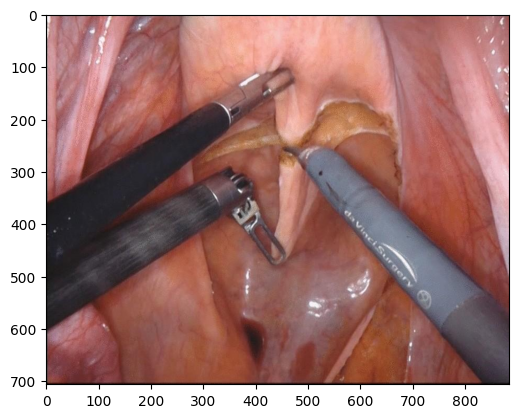

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

local_image_path = "inpaint_demo.jpg"
image_url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"

download_image(image_url, local_image_path)
image_source, image = load_image(local_image_path)
plt.imshow(image_source)

In [54]:
class perturbation_class:

    def gamma_correction(img):
        seq = []
        gammas = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]#np.arange(1,0.1,-.03)
        img = Image.fromarray(img)
        for i in range(len(gammas)):
            z = TF.adjust_gamma(img, gammas[i], gain=1)
            seq.append(z)
        return seq

    def contrast(img):
        seq = []
        factors = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
        img = Image.fromarray(img)
        for i in range(len(factors)):
            z = TF.adjust_contrast(img, factors[i])
            seq.append(z)
        return seq

    def brightness(img):
        seq = []
        factors = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
        img = Image.fromarray(img)
        for i in range(len(factors)):
            z = TF.adjust_brightness(img, factors[i])
            seq.append(z)
        return seq

    def sharpness(img):
        seq = []
        #factors = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
        factors = [ -6, -4, -2, 1, 2, 4, 6]
        img = Image.fromarray(img)
        for i in range(len(factors)):
            z = TF.adjust_sharpness(img, factors[i])
            seq.append(z)
        return seq

    def gaussian_blur(img):
        seq = []
        #Question for Mobarak, how did you determine these kernel sizes?
        ksize = [1, 3, 5, 7, 9, 11, 51]
        img = Image.fromarray(img)
        for i in range(len(ksize)):
            z = TF.gaussian_blur(img, kernel_size=ksize[i])
            seq.append(np.array(z))
        return seq

    def center_crop(img):
        seq = []
        sizes = [50, 150, 250, 350, 450, 550, 700]
        img = Image.fromarray(img)
        for i in range(len(sizes)):
            z = TF.gaussian_blur(img, sizes[i])
            seq.append(np.array(z))
        return seq


ValueError: ignored

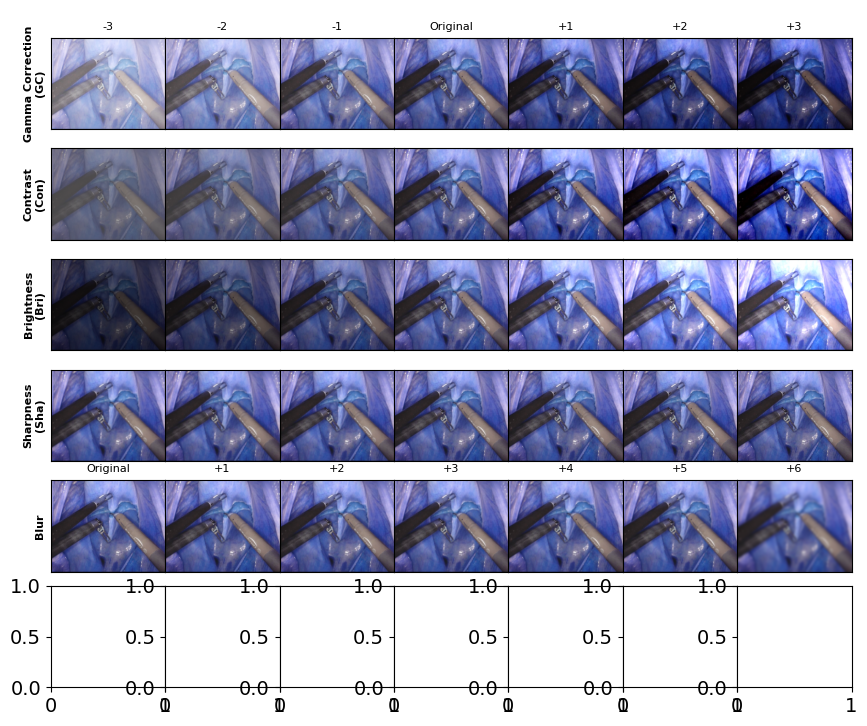

In [56]:
img_dir = 'inpaint_demo.jpg'
original = cv2.imread(img_dir)
plt.rcParams.update({'font.size': 14})
# perturbation_all = ['brightness', 'contrast','gamma_correction','sharpness','gaussian_blur', 'center_crop']
# filter_name = ['Brightness', 'Contrast','Gamma Correction','Sharpness','Gaussian blur', 'center_crop']
ptech_list = ['Original', '+1', '+2', '+3', '+4', '+5', '+6']
f_size = 8
perturbation_all = ['gamma_correction', 'contrast', 'brightness', 'sharpness','gaussian_blur', 'center_crop']
#filter_name = ['Gamma Correction (GC)', 'Contrast (Con)', 'Brightness (Bri)', 'Sharpness (Sha)','Blur', 'Center Crop']
filter_name = ['Gamma Correction\n(GC)', 'Contrast\n(Con)', 'Brightness\n(Bri)', 'Sharpness\n(Sha)','Blur', 'Center Crop']
seq_all = [0, 1, 2, 3, 4, 5, 6]
levels = ['-3','-2','-1','Original','+1','+2','+3']
levels_real = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
fig_per_row = len(seq_all)
fig, ax = plt.subplots(len(perturbation_all), fig_per_row, figsize=(31/3, 25.5/3), gridspec_kw=dict(wspace=0.00, hspace=0.09))
for p_idx, per in enumerate(perturbation_all):
    class_method = getattr(perturbation_class, per)
    seq = class_method(original)
    for idx, seq_idx in enumerate(seq_all):
        if p_idx == 4:
            ax[p_idx, idx].set_title('{}'.format(ptech_list[idx]), fontsize=f_size)
        if idx == 3:
            ax[p_idx, idx].imshow(seq[seq_idx], cmap='gray')
        else:
            ax[p_idx, idx].imshow(seq[seq_idx], cmap='gray')

        if p_idx == 0:
            if levels[idx] == 'Original':
                ax[p_idx, idx].set_title('\n{}'.format(levels[idx]), fontsize=f_size)
            else:
                ax[p_idx, idx].set_title('{}'.format(levels[idx], levels_real[idx]), fontsize=f_size)
        if idx == 0:
            ax[p_idx, idx].set_ylabel(filter_name[p_idx], fontsize=f_size, fontweight="bold")

        ax[p_idx, idx].xaxis.set_major_locator(plt.NullLocator())
        ax[p_idx, idx].yaxis.set_major_locator(plt.NullLocator())


fig.show()
plt.savefig('perturbation_effect_v2.pdf',dpi=100)

Geometrical Deviation

Cropping

Adversarial Attacks (for M)

Grounding DINO to Detect Object with Prompt

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


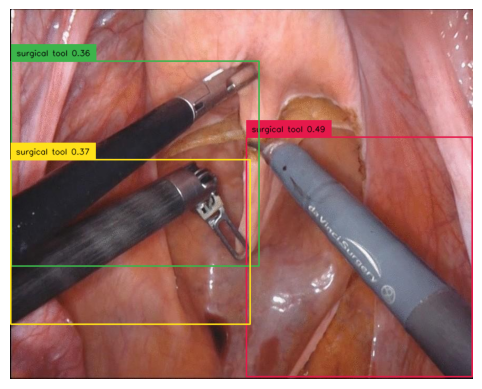

In [ ]:
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
import matplotlib.pyplot as plt

def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)


def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes

annotated_frame, detected_boxes = detect(image, text_prompt="surgical tool", model=groundingdino_model)
predicted_img = Image.fromarray(annotated_frame)
plt.imshow(predicted_img)
plt.axis('OFF');

MSE error:

In [ ]:
detected_boxes

tensor([[0.7550, 0.6704, 0.4873, 0.6478],
        [0.2704, 0.4182, 0.5357, 0.5535],
        [0.2601, 0.6302, 0.5168, 0.4449]])

SAM for Segmentation from Detected Bounding Box:

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!pip -q install 'git+https://github.com/facebookresearch/segment-anything.git'

--2023-09-19 16:41:30--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.160.61, 99.84.160.46, 99.84.160.80, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.160.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  68.1MB/s    in 37s     

2023-09-19 16:42:07 (66.7 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

  Preparing metadata (setup.py) ... done


Restart Runtime, please! (if segment_anything not found)

In [ ]:
%cd /content/Grounded-Segment-Anything
from segment_anything import build_sam, SamPredictor
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

/content/Grounded-Segment-Anything


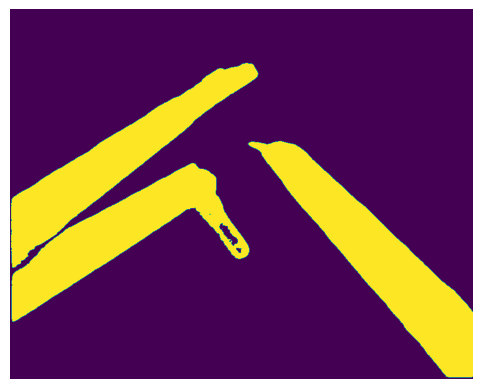

In [ ]:
import numpy as np

def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))


segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
# annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
# instance_seg1 = Image.fromarray(annotated_frame_with_mask)
binary_seg = segmented_frame_masks.squeeze().any(axis=0)
plt.imshow(binary_seg);
plt.axis('OFF');

Intersection over Union (IoU)